<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [1]:
#Import necessary modules for Google Colab to mount Google Drive and authenticate user
from google.colab import drive
from google.colab import auth

#Mount Google Drive and authenticate user to access Google services
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Mounted at /content/drive
Authenticated


#Load Packages

In [2]:
#Import necessary packages for Google BigQuery and data processing
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

#Install and import the geoip2 package for geolocation
!pip install geoip2
import geoip2.database

#Import additional packages for time management, machine learning, and data scaling
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.optimizers import Adam

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.4 MB/s eta 0:00:00
Cloning into 'CAS_ADS_Final_Project'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 159 (delta 46), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (159/159), 5.52 MiB | 10.51 MiB/s, done.
Resolving deltas: 100% (46/46), done.


# Connect to Big Query and Get Data

In [3]:
#Set up Google BigQuery client with the specified project ID
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)
#Fraud cases - (TC40/Safe -  run the model against Fraud cases only)!

#Query to select fraud and non-fraud cases from the dataset
Query = """
Select distinct * from (
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)
union all
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (
Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id not in (Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)) limit 5000))
where Clientinfo_email not like ('%fibonatix.com') and Clientinfo_email not like ('%@fibonaitx.com');
"""
#prev limit:12869
#Validation set 2024
#Execute the query and convert the results to a Pandas DataFrame
Query_Results = bigquery_client.query(Query)
Data_Adf = Query_Results.to_dataframe()

#Remove duplicate records based on the 'id' column
Data_Adf = Data_Adf.drop_duplicates(subset=['id'])
Data_Adf

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud
0,7473644,GhLYQi7N,VzVkHe0l,200.000000000,158.230000000,185.203.122.87,2023-02-21 09:20:42+00:00,95209143053000009096499,None,<NA>,...,11,5815,"Digital Goods Media – Books, Movies, Digital a...",2022-11-13 15:45:24+00:00,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,FR
1,7354431,aDgRF4iJ,AJlxJMif,250.000000000,146.020000000,34.176.122.28,2023-02-07 18:13:03+00:00,74595343039000008611381,None,<NA>,...,9,8299,Schools & Educational Services (Not Elsewhere ...,2022-11-13 15:43:58+00:00,NaT,349,Gabi Behiri,2024-03-27 14:00:43+00:00,NaT,FR
2,2121615,KszEEcl5,JbLgHxcM,67.000000000,53.650000000,68.228.159.182,2021-01-09 07:47:44+00:00,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
3,2179679,RovxBOeQ,b8yfDlgl,67.000000000,53.650000000,97.81.112.167,2021-01-19 05:37:44+00:00,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
4,2165473,QXk4Cu6x,o7CjRI8t,67.000000000,53.650000000,2603:8000:ba00:9900:4823:5007:5e1b:bbce,2021-01-16 09:37:02+00:00,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28667,7658049,iICzFOca,4iVL0R8Y,80.940000000,69.390000000,2001:14bb:ae:cd66:9438:db80:fc96:c1a6,2023-03-10 20:25:25+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None
28668,7905996,Lgx6H736,ESPtdkzW,63.480000000,54.420000000,46.176.5.30,2023-04-04 18:52:46+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None
28669,9544528,hOyU8Ciz,ZXrfbTqc,296.190000000,254.210000000,2a02:587:3519:600:a0a6:9107:5c21:52e2,2023-09-19 11:49:08+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None
28670,10108765,jbR1CS64,u97Tkeme,43.770000000,37.570000000,2a02:587:1e10:84d0:bc2c:4258:7798:ec60,2023-11-24 16:56:17+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None


#Check whether there are any duplicate ID's

In [4]:
duplicate_rows = Data_Adf[Data_Adf.duplicated(subset=['id'])]
duplicate_rows

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud


In [5]:
# Check for emails ending with "fibonatix.com" or "@fibonaitx.com"
mask_fibonatix = Data_Adf['Clientinfo_email'].str.endswith('fibonatix.com')
mask_fibonaitx = Data_Adf['Clientinfo_email'].str.endswith('fibonaitx.com')

# Combine both masks
mask = mask_fibonatix | mask_fibonaitx

# Filter DataFrame
filtered_df = Data_Adf[mask]

# Check if any such emails exist
if not filtered_df.empty:
    print("Emails ending with 'fibonatix.com' or 'fibonaitx.com' exist in the DataFrame.")
    print(filtered_df)
else:
    print("No emails ending with 'fibonatix.com' or 'fibonaitx.com' exist in the DataFrame.")


No emails ending with 'fibonatix.com' or 'fibonaitx.com' exist in the DataFrame.


#Conversion and Creation of Variables

In [6]:
#Function to convert columns to float type
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

#Function to convert columns to string type
def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

#Define columns to be converted to string and float
columns_to_string = ['id']
columns_to_float = ['amount_gbp']

#Convert specified columns to float and string types
convert_float(columns_to_float)
convert_string(columns_to_string)

#Replace 'None' with a placeholder value & map string values to boolean values
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].fillna('Missing')
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].map({'Missing': False, 'FR': True})

#Data Analysis

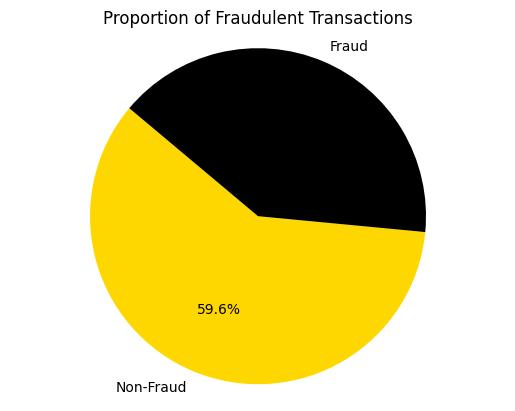

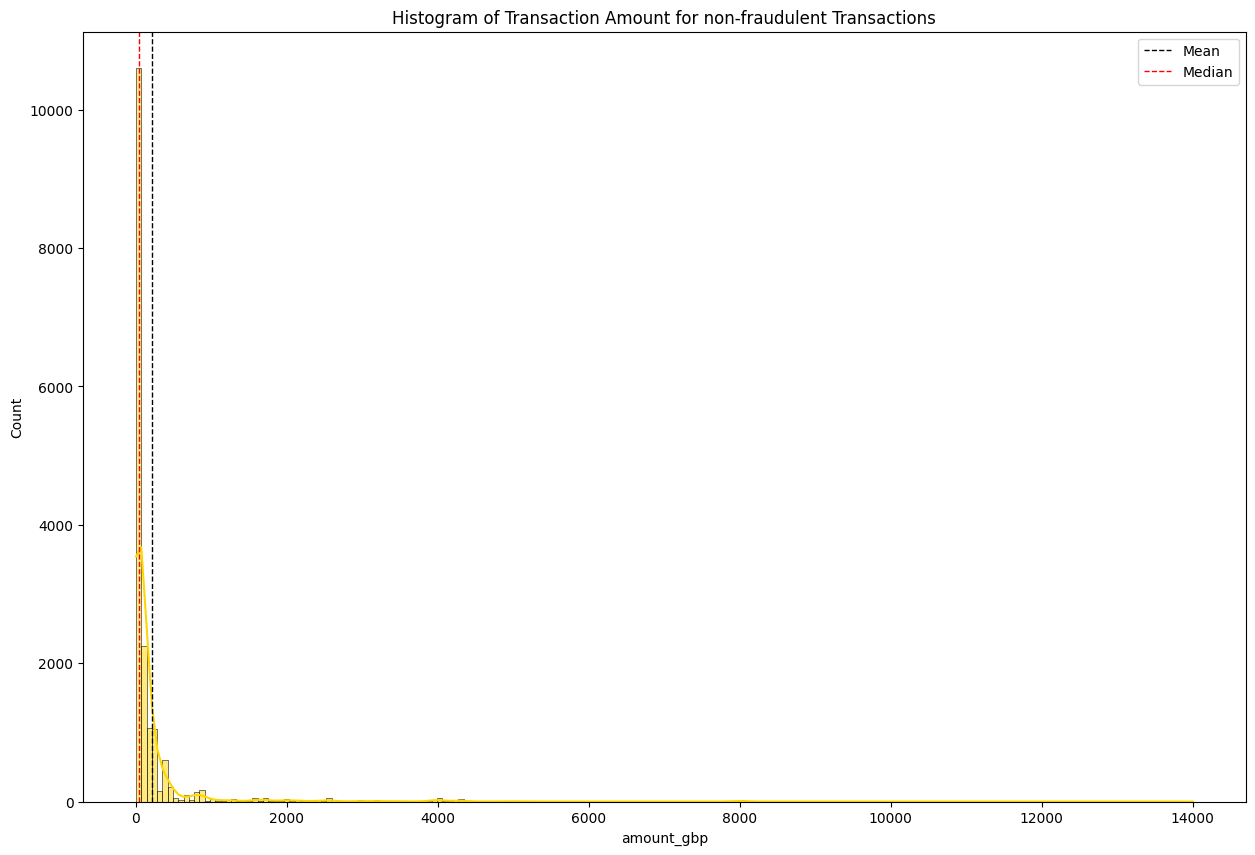

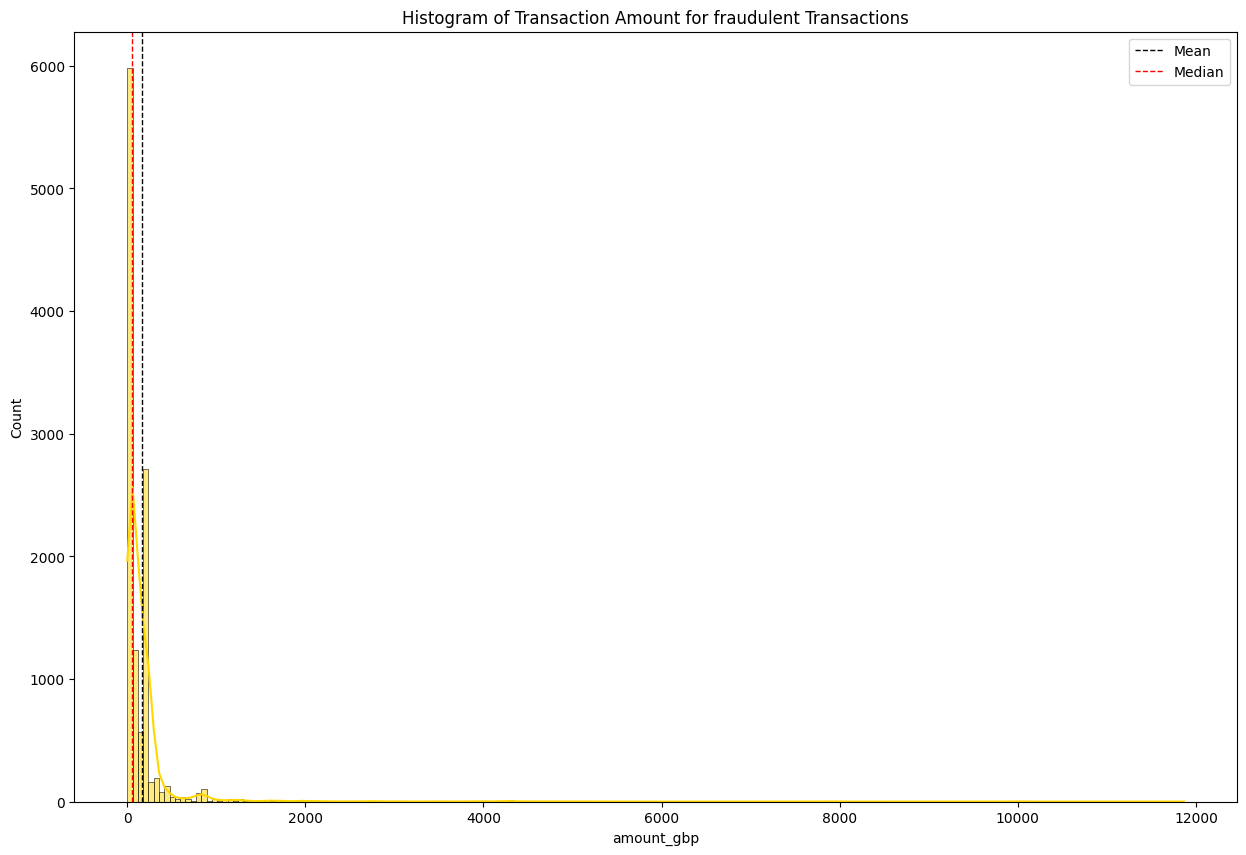

In [7]:
#Visualization of share of fraudulent vs. non-fraudulent transactions (trx) using a pie chart
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check the amount distribution of fraudulent vs. non-fraudulent trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Plotting of histogram of transaction amount for non-fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for non-fraudulent Transactions")
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Plotting of histogram of transaction amount for fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for fraudulent Transactions")
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [8]:
#Calcualte Customer Profile Statistics: mean, median and standard deviation of transaction amount per client
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']

#Calcualte Average Number of trx per day per customer
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge datasets to combine customer profile statistics
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.650,53.650,1.0
1,1058557,53.650,53.650,1.0
2,1058568,157.750,157.750,1.0
3,1058569,157.750,157.750,1.0
4,1058596,137.735,137.735,1.0
...,...,...,...,...
15341,4640416,48.980,48.980,1.0
15342,4640558,396.330,396.330,1.0
15343,4640697,388.360,388.360,1.0
15344,4641367,25.900,25.900,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [9]:
#Function to get country information from an IP address
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

#Read country latitude and longitude data from a CSV file
df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')

In [10]:
#Get Customer Device IP coordinates (country) and use get_country function to get country information
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

#Merge country information with latitude and longitude data
merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

,id,client_id,latitude_ip,longitude_ip
0,7473644,3282698,-30.559482,22.937506
1,7354431,3242532,NaN,NaN
2,2121615,1169474,NaN,NaN
3,2179679,1191053,NaN,NaN
4,2165473,1181624,NaN,NaN
...,...,...,...,...
28666,7658049,1538595,61.924110,25.748151
28667,7905996,2636121,39.074208,21.824312
28668,9544528,3942540,39.074208,21.824312
28669,10108765,4003234,39.074208,21.824312


In [11]:
#Get customer card issuer bank coordinates (country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()

#Fill NaN values with 0 and rename column for consistency
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)

#Merge country information with latitude and longitude data
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,7473644,3282698,-30.559482,22.937506
1,7354431,3242532,23.634501,-102.552784
2,2121615,1169474,NaN,NaN
3,2179679,1191053,NaN,NaN
4,2165473,1181624,NaN,NaN
...,...,...,...,...
28666,7658049,1538595,61.924110,25.748151
28667,7905996,2636121,39.074208,21.824312
28668,9544528,3942540,39.074208,21.824312
28669,10108765,4003234,39.074208,21.824312


In [12]:
#Merge country profiles based on ID
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,how = 'left', on='id')

#Select relevant columns and rename them
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns
old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
7473644,3282698,-30.559482,22.937506,-30.559482,22.937506
7354431,3242532,NaN,NaN,23.634501,-102.552784
2121615,1169474,NaN,NaN,NaN,NaN
2179679,1191053,NaN,NaN,NaN,NaN
2165473,1181624,NaN,NaN,NaN,NaN
...,...,...,...,...,...
7658049,1538595,61.924110,25.748151,61.924110,25.748151
7905996,2636121,39.074208,21.824312,39.074208,21.824312
9544528,3942540,39.074208,21.824312,39.074208,21.824312


# Get Transaction Profile (Trx_Profile)

In [13]:
#Function to convert time to seconds
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

#Function to check if a date is a weekend
def is_weekend(date):
    return date.weekday() >= 5

#Function to calculate client spending behavior features over various rolling window sizes of customer transactions
def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

#Get is_night feature
Trx_Profile.loc[:,'hour'] = Trx_Profile['timestamp'].dt.hour
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['hour'] >= 22) | (Trx_Profile['hour'] < 4)
Trx_Profile.loc[:,'is_night?'] = Trx_Profile.loc[:,'is_night?'].astype(int)

#Drop unnecessary columns and rename
columns_to_drop = ['time','date','hour']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}
Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
7473644,2023-02-21 09:20:43+00:00,3282698,158.23,33643,0,0
7354431,2023-02-07 18:13:04+00:00,3242532,146.02,65584,0,0
2121615,2021-01-09 07:47:44+00:00,1169474,53.65,28064,1,0
2179679,2021-01-19 05:37:44+00:00,1191053,53.65,20264,0,0
2165473,2021-01-16 09:37:01+00:00,1181624,53.65,34621,1,0
...,...,...,...,...,...,...
7658049,2023-03-10 20:25:26+00:00,1538595,69.39,73526,0,0
7905996,2023-04-04 18:52:47+00:00,2636121,54.42,67967,0,0
9544528,2023-09-19 11:49:10+00:00,3942540,254.21,42550,0,0


# Get Customer Behaviour Profile (Trx_Profile_Rolling)

In [14]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

#Convert timestamp to datetime without timezone
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and client ID
Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate customer spending behavior features
%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

#Set 'id' column as index and convert it to integer type
Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 1min 27s, sys: 1.52 s, total: 1min 28s
Wall time: 1min 28s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983596,2021-01-01 01:57:49,1058596,37.64,1.0,37.64,1.0,37.64,1.0,37.64
...,...,...,...,...,...,...,...,...,...
11582520,2024-04-30 09:04:30,4640416,48.98,1.0,48.98,1.0,48.98,1.0,48.98
11583062,2024-04-30 10:02:57,4640558,396.33,1.0,396.33,1.0,396.33,1.0,396.33
11583367,2024-04-30 10:33:07,4640697,388.36,1.0,388.36,1.0,388.36,1.0,388.36


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [15]:
#Function to calculate spending behavior features of a brand over various rolling window sizes of customer transactions
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].shift(1).rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].shift(1).rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

#Create a new column for fraudulent transaction amounts
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

#Extract relevant columns for Brand Fraud Profile
Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

#Convert timestamp to datetime without timezone
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and brand ID
Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate brand fraud profile features
%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

#Set 'id' column as index and convert it to integer type
Brand_Fraud_Profile.set_index('id',inplace=True)
Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

#Drop the 'amount_gbp_fraud_trx' column
Brand_Fraud_Profile = Brand_Fraud_Profile.drop('amount_gbp_fraud_trx', axis=1)
Brand_Fraud_Profile

CPU times: user 1.61 s, sys: 29.1 ms, total: 1.64 s
Wall time: 1.63 s


,timestamp,Brands_id,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,
1989686,2021-01-02 18:18:00,1234,0.0,NaN,0.0,NaN,0.0,NaN
1999498,2021-01-04 21:42:57,1234,1.0,53.65,1.0,53.65,1.0,53.65
2000741,2021-01-05 09:13:35,1234,2.0,105.70,2.0,105.70,2.0,105.70
2001827,2021-01-05 09:31:50,1234,2.0,105.70,2.0,105.70,2.0,105.70
2059116,2021-01-06 06:35:13,1234,2.0,105.70,3.0,88.35,3.0,88.35
...,...,...,...,...,...,...,...,...
11589011,2024-04-30 20:29:15,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589186,2024-04-30 21:00:16,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589201,2024-04-30 21:02:30,851571,0.0,NaN,0.0,NaN,0.0,NaN


In [16]:
abc = Trx_Profile_Rolling.copy()
xyz = Brand_Fraud_Profile.copy()

abc = abc.reset_index(level='id') #Key is id
xyz = xyz.reset_index(level='id') #Key is id

# Convert 'id' column to sets for faster comparison
id_set1 = set(abc['id'])
id_set2 = set(xyz['id'])

# Find missing IDs in df2
missing_ids = id_set1 - id_set2

print("Missing IDs in df2:", missing_ids)


Missing IDs in df2: {11469893}


# Get All Dummy Variables (Data_Dummies)

In [17]:
#Creating a copy of the original data frame with the needed columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()

#Extract email domain
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating dummy variables for categorical columns, dropping email column and converting columns to integer type
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

# Set 'id' column as index
Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_MYR,Currency_name_USD,Currency_name_ZAR,Environments_name_PrestaShop,...,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_ITG,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
7473644,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
7354431,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2121615,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2179679,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2165473,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7658049,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7905996,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9544528,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Merge all Datasets into a Single Dataset

In [18]:
#Rest indexs in all dataframes in preparation to merge
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id

In [19]:
#Extract fraud flag column and convert to integer type
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag.loc[:, 'id'] = DF_Flag['id'].astype(int)
DF_Flag.loc[:, 'Is_fraud'] = DF_Flag['Is_fraud'].astype(int)

#Add the previously newly created attributes to the id and fraud flag dataset with a merge
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

##only when Testing With Full Dataset

In [20]:
#Add the dummies dataset with a merge
DF5 = pd.merge(DF4, Data_Dummies, how='left', on='id')

##only when Testing Without Profiles

In [21]:
#Merge Data_Dummies and DF_Flag and add timestamp
DF_x = pd.merge(Data_Dummies, DF_Flag, how='left', on='id')

# Balancing Dataset

In [22]:
#Selecting subset with fraudulent and non-fraudulent trx and removing duplicate rows based on the 'id' column
#For Testing Without Dummies & Coordinates (_wodc)
ones_subset_wodc = DF4.loc[DF4["Is_fraud"] == 1]
zeros_subset_wodc = DF4.loc[DF4["Is_fraud"] == 0]
#For Testing Without Profiles (_wop)
ones_subset_wop = DF_x.loc[DF_x["Is_fraud"] == 1]
zeros_subset_wop = DF_x.loc[DF_x["Is_fraud"] == 0]
#For Testing With Full Dataset (_fd)
ones_subset_fd = DF5.loc[DF5["Is_fraud"] == 1]
zeros_subset_fd = DF5.loc[DF5["Is_fraud"] == 0]

#Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones_wodc = len(ones_subset_wodc)
sampled_zeros_wodc = zeros_subset_wodc.sample(number_of_ones_wodc, random_state=42)
number_of_ones_wop = len(ones_subset_wop)
sampled_zeros_wop = zeros_subset_wop.sample(number_of_ones_wop, random_state=42)
number_of_ones_fd = len(ones_subset_fd)
sampled_zeros_fd = zeros_subset_fd.sample(number_of_ones_fd, random_state=42)

#Concatenate the sampled null values with the non-null values
balanced_df_wodc = pd.concat([ones_subset_wodc, sampled_zeros_wodc], ignore_index=True)
balanced_df_wop = pd.concat([ones_subset_wop, sampled_zeros_wop], ignore_index=True)
balanced_df_fd = pd.concat([ones_subset_fd, sampled_zeros_fd], ignore_index=True)

#Copy Dataset & account for Null Values
DS_wodc = balanced_df_wodc.copy()
DS_wodc.replace('<NA>', np.nan, inplace=True)
DS_wop = balanced_df_wop.copy()
DS_wop.replace('<NA>', np.nan, inplace=True)
DS_fd = balanced_df_fd.copy()
DS_fd.replace('<NA>', np.nan, inplace=True)

#Splitting into Training, Test, and Validation Set

In [23]:
# Define the start and end dates for each split
train_start_date = '1970-01-01'
train_end_date = '2023-10-31'
test_start_date = '2023-11-01'
test_end_date = '2024-01-31'
val_start_date = '2024-02-01'
val_end_date = DS_wodc['timestamp'].max()

##Only run one of the following three:

###when Testing With Full Dataset

In [24]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_fd['timestamp'] = pd.to_datetime(DS_fd['timestamp'])

# Perform the split based on timestamp
train_set = DS_fd[(DS_fd['timestamp'] >= train_start_date) & (DS_fd['timestamp'] <= train_end_date)]
test_set = DS_fd[(DS_fd['timestamp'] >= test_start_date) & (DS_fd['timestamp'] <= test_end_date)]
val_set = DS_fd[(DS_fd['timestamp'] >= val_start_date) & (DS_fd['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# # Print or use these DataFrames as needed
# print("Train set after dropping columns:", train)
# print("Test set after dropping columns:", test)
# print("Validation set after dropping columns:", val)

Train set length: 18619
Test set length: 2465
Validation set length: 2006


###when Testing Without Dummies & Coordinates

In [25]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wodc['timestamp'] = pd.to_datetime(DS_wodc['timestamp'])

# Perform the split based on timestamp
train_set = DS_wodc[(DS_wodc['timestamp'] >= train_start_date) & (DS_wodc['timestamp'] <= train_end_date)]
test_set = DS_wodc[(DS_wodc['timestamp'] >= test_start_date) & (DS_wodc['timestamp'] <= test_end_date)]
val_set = DS_wodc[(DS_wodc['timestamp'] >= val_start_date) & (DS_wodc['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp'] + ['latitude_ip']+ ['longitude_ip']+ ['latitude_card']+ ['longitude_card']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# # Print or use these DataFrames as needed
# print("Train set after dropping columns:", train)
# print("Test set after dropping columns:", test)
# print("Validation set after dropping columns:", val)

Train set length: 18619
Test set length: 2465
Validation set length: 2006


###when Testing Without Profiles

In [26]:
# Convert the "id" column in Data_Adf to the same data type as in DS_wop
Data_Adf['id'] = Data_Adf['id'].astype(int)

# Merge DS_wop and Data_Adf on the "id" column
DS_wop = pd.merge(DS_wop, Data_Adf[['id', 'processor_timestamp']], how='left', on='id')

# Rename the "processor_timestamp" column to "timestamp"
DS_wop.rename(columns={'processor_timestamp': 'timestamp'}, inplace=True)

# Convert the "timestamp" column to datetime format
DS_wop['timestamp'] = pd.to_datetime(DS_wop['timestamp'])
DS_wop['timestamp'] = DS_wop['timestamp'].dt.tz_localize(None)
DS_wop['timestamp'] = DS_wop['timestamp'].astype('datetime64[ns]')

In [27]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wop['timestamp'] = pd.to_datetime(DS_wop['timestamp'])

# Perform the split based on timestamp
train_set = DS_wop[(DS_wop['timestamp'] >= train_start_date) & (DS_wop['timestamp'] <= train_end_date)]
test_set = DS_wop[(DS_wop['timestamp'] >= test_start_date) & (DS_wop['timestamp'] <= test_end_date)]
val_set = DS_wop[(DS_wop['timestamp'] >= val_start_date) & (DS_wop['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
#print("Train set after dropping columns:", train)
#print("Test set after dropping columns:", test)
#print("Validation set after dropping columns:", val)

Train set length: 17167
Test set length: 2465
Validation set length: 2005
Train set after dropping columns:        Currency_name_AUD  Currency_name_CAD  Currency_name_CHF  \
0                      0                  0                  0   
1                      0                  1                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
...                  ...                ...                ...   
23159                  0                  0                  0   
23160                  0                  0                  0   
23161                  0                  0                  0   
23162                  0                  0                  0   
23163                  0                  0                  0   

       Currency_name_EUR  Currency_name_GBP  Currency_name_INR  \
0                      0         

#Define y and X variables

In [28]:
# Define y and X variables for train, test, and val sets
y_train, X_train = train['Is_fraud'], train.drop(columns=['Is_fraud'])
y_test, X_test = test['Is_fraud'], test.drop(columns=['Is_fraud'])
y_val, X_val = val['Is_fraud'], val.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Logistic Regression Model

##Different Hyperparameters

##Testing and comparing different hyperparameters

In [82]:
#Define lists to store evaluation metrics
log_accuracy_list = []
log_precision_list = []
log_recall_list = []
log_f1_score_list = []

#Define a list of hyperparameters to try
hyperparameters = [
    {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'tol': 1e-4},
    {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'tol': 1e-4},
    {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'tol': 1e-4},
    {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'tol': 1e-3},
    {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None, 'tol': 1e-4},
    {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None, 'tol': 1e-4}
]

#Loop through each set of hyperparameters
for params in hyperparameters:
    #Initialize Logistic Regression model with custom hyperparameters
    model = LogisticRegression(random_state=42, max_iter=1000, **params)

    #Train the model
    model.fit(X_train_pca, y_train)

    #Predictions
    y_pred = model.predict(X_val_pca)

    #Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')

    #Append metrics to lists
    log_accuracy_list.append(accuracy)
    log_precision_list.append(precision)
    log_recall_list.append(recall)
    log_f1_score_list.append(f1_score)

##Plotting the results

[['0.1,l2,lbfgs,None,0.0001'], ['1.0,l2,lbfgs,None,0.0001'], ['10.0,l2,lbfgs,None,0.0001'], ['1.0,l2,lbfgs,balanced,0.001'], ['1.0,l1,liblinear,None,0.0001'], ['10.0,l1,liblinear,None,0.0001']]


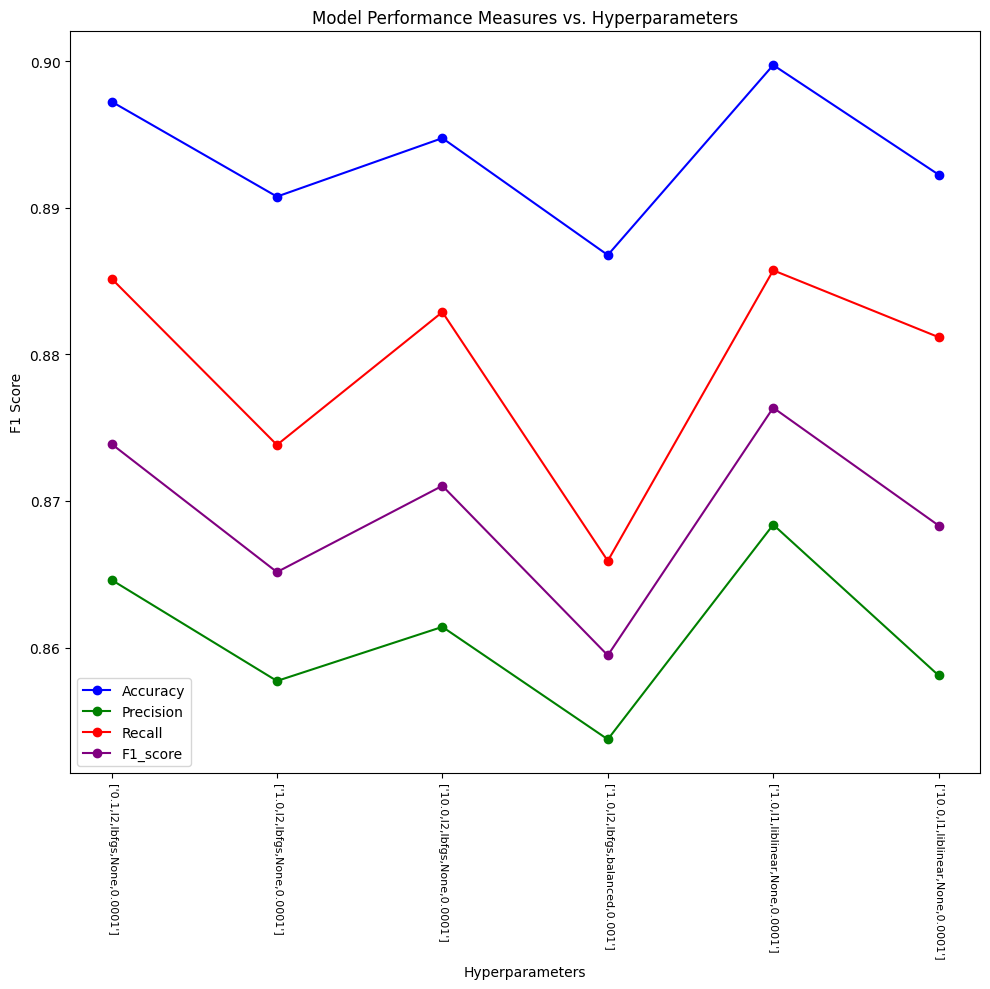

In [149]:
#Plot the results

c = []
for i in range(len(hyperparameters)):
  b = []
  for keys, values in hyperparameters[i].items():
    b.append(values)
  c.append(b)

label = []
for i in c:
  temp = []
  xlabel = f'{i[0]},{i[1]},{i[2]},{i[3]},{i[4]}'
  temp.append(xlabel)
  label.append(temp)

print(label)
plt.figure(figsize=(10, 10))

#Accuracy plot
#plt.subplot(2, 2, 1)
plt.plot(range(len(hyperparameters)), log_accuracy_list, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xticks(range(len(hyperparameters)), label, rotation=-90,fontsize=8)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Hyperparameters')


#Precision plot
#plt.subplot(2, 2, 2)
plt.plot(range(len(hyperparameters)), log_precision_list, marker='o', linestyle='-', color='g',label='Precision')
plt.xticks(range(len(hyperparameters)), label, rotation=-90,fontsize=8)
plt.xlabel('Hyperparameters')
plt.ylabel('Precision')
plt.title('Precision vs. Hyperparameters')

#Recall plot
#plt.subplot(2, 2, 3)
plt.plot(range(len(hyperparameters)), log_recall_list, marker='o', linestyle='-', color='r', label='Recall')
plt.xticks(range(len(hyperparameters)), label, rotation=-90,fontsize=8)
plt.xlabel('Hyperparameters')
plt.ylabel('Recall')
plt.title('Recall vs. Hyperparameters')

#F1-score plot
#plt.subplot(2, 2, 4)
plt.plot(range(len(hyperparameters)), log_f1_score_list, marker='o', linestyle='-', color='purple',label='F1_score')
plt.xticks(range(len(hyperparameters)), label, rotation=-90,fontsize=8)
plt.xlabel('Hyperparameters')
plt.ylabel('F1 Score')
plt.title('Model Performance Measures vs. Hyperparameters')

plt.tight_layout()
plt.legend()
plt.show()


##Final Model

In [31]:
#Apply best weights
# weights = {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'tol': 1e-3}
weights = {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'tol': 1e-4}

# Train a Logistic Regression model with specified weights
model = LogisticRegression(**weights, random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test_pca)

# Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred = model.predict(X_val_pca)

# Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Test set evaluation:
[[1419   60]
 [ 115  871]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1479
           1       0.94      0.88      0.91       986

    accuracy                           0.93      2465
   macro avg       0.93      0.92      0.93      2465
weighted avg       0.93      0.93      0.93      2465

Validation set evaluation:
[[1330  130]
 [  89  456]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1460
           1       0.78      0.84      0.81       545

    accuracy                           0.89      2005
   macro avg       0.86      0.87      0.87      2005
weighted avg       0.89      0.89      0.89      2005



##See PCA Details

Feature: Issuers_name_UBS_SWITZERLAND_AG, Importance Score: -3.463704712660754
Feature: Issuers_name_BNP_PARIBAS, Importance Score: 2.9566209637644154
Feature: Issuers_name_HSBC_UK_BANK_PLC, Importance Score: -2.6167496859270427
Feature: Issuers_name_BANK_OF_NOVA_SCOTIA, Importance Score: 2.608723703384466
Feature: Issuers_name_COMMONWEALTH_BANK_OF_AUSTRALIA, Importance Score: 2.5677535942569643
Feature: Deviceinfo_device_name_Samsung_SM-A515F, Importance Score: -2.48345789892934
Feature: Issuers_name_REVOLUT_LTD, Importance Score: -2.4786497722496947
Feature: Issuers_name_CONSUMERS_COOPERATIVE_C.U., Importance Score: -2.3161254802660807
Feature: Issuers_name_S-PANKKI_OY_(S-BANK_LIMITED), Importance Score: -2.1329346621076852
Feature: Issuers_name_TORONTO-DOMINION_BANK, Importance Score: 2.1084010363931736


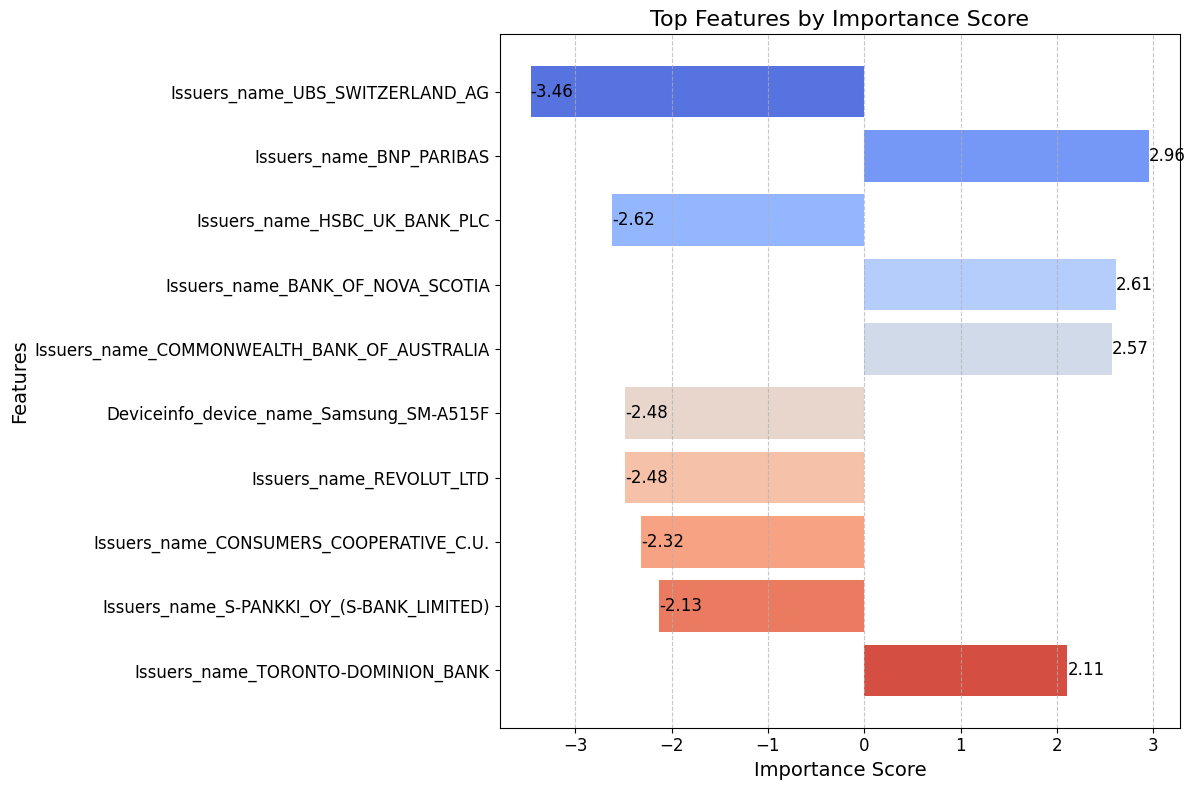

In [32]:
#Get the coefficients of the logistic regression model
coefficients = model.coef_

#Get the principal components
components = pca.components_

#Map the coefficients back to the original features
feature_importance = np.dot(coefficients, components)

#Analyze the feature importance
feature_importance_abs = np.abs(feature_importance)
sorted_indices = np.argsort(feature_importance_abs)[0][::-1]  #Sort indices by absolute magnitude

# Print the top N features and visualize
top_n = 10  # Change this value according to your preference
top_features = []
top_scores = []

for i in range(top_n):
    feature_index = sorted_indices[i]
    feature_name = X_train.columns[feature_index]  # Assuming X_train is a DataFrame
    importance_score = feature_importance[0][feature_index]
    top_features.append(feature_name)
    top_scores.append(importance_score)
    print(f"Feature: {feature_name}, Importance Score: {importance_score}")

# Plotting
# plt.figure(figsize=(10, 6))
# plt.barh(top_features[::-1], top_scores[::-1], color='skyblue')  # Reverse the order for a better visual effect
# plt.xlabel('Importance Score')
# plt.title('Top {} Features by Importance Score'.format(top_n))
# plt.show()

# Plotting
plt.figure(figsize=(12, 8))
colors = sns.color_palette("coolwarm", n_colors=len(top_features))
plt.barh(top_features[::-1], top_scores[::-1], color=colors[::-1])  # Reverse the order for a better visual effect
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top Features by Importance Score', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Adding the value of importance scores at the end of bars
for i, v in enumerate(top_scores[::-1]):
    plt.text(v, i, f"{v:.2f}", color='black', va='center', fontsize=12)

plt.show()

Top 10 Contributors:
Component 1: Variance Explained: 15.38%
Component 2: Variance Explained: 11.03%
Component 3: Variance Explained: 5.31%
Component 4: Variance Explained: 4.31%
Component 5: Variance Explained: 3.89%
Component 6: Variance Explained: 3.79%
Component 7: Variance Explained: 3.12%
Component 8: Variance Explained: 2.69%
Component 9: Variance Explained: 2.43%
Component 10: Variance Explained: 2.23%


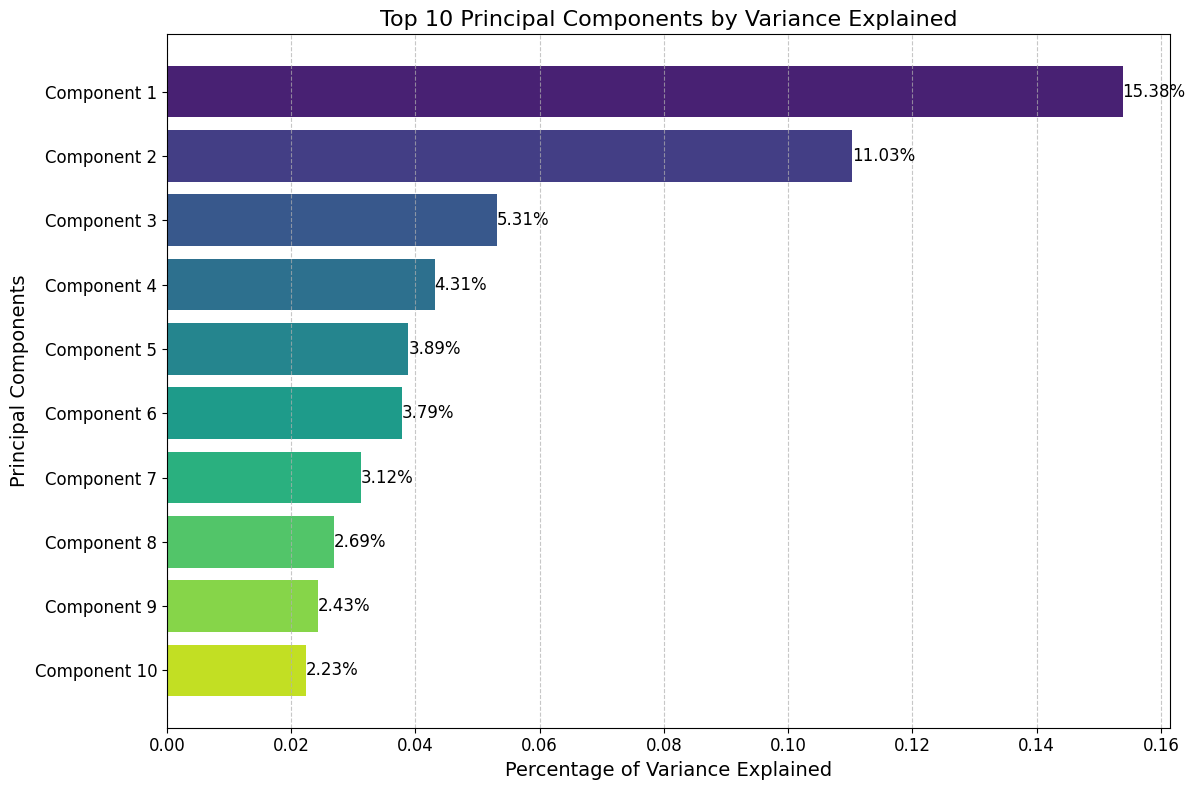

In [33]:
#Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

#Get the indices of the top contributors
top_contributors_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Prepare data for plotting
# top_variance_explained = explained_variance_ratio[top_contributors_indices]
top_variance_explained = np.concatenate([explained_variance_ratio[top_contributors_indices], np.zeros(10 - len(top_contributors_indices))])
top_components = [f'Component {i+1}' for i in range(10)]

# Print the top contributors along with their percentages of variance explained
print("Top 10 Contributors:")
for i, idx in enumerate(top_contributors_indices):
    print(f"Component {i+1}: Variance Explained: {explained_variance_ratio[idx]*100:.2f}%")

# Plotting
plt.figure(figsize=(12, 8))
colors = sns.color_palette("viridis", n_colors=len(top_components))
plt.barh(top_components[::-1], top_variance_explained[::-1], color=colors[::-1])
plt.xlabel('Percentage of Variance Explained', fontsize=14)
plt.ylabel('Principal Components', fontsize=14)
plt.title('Top 10 Principal Components by Variance Explained', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Adding the percentage of variance explained at the end of bars
for i, v in enumerate(top_variance_explained[::-1]):
    plt.text(v, i, f"{v*100:.2f}%", color='black', va='center', fontsize=12)

# Show the plot
plt.show()


Components of Component 1:
                                                Feature  Component Weight  \
2735  Industries_name_Online_Professional_Courses_Pr...         -0.379809   
2920                                Processors_name_WLN         -0.365755   
7                                     Currency_name_USD         -0.358865   
3                                     Currency_name_EUR          0.311851   
2796          Companies_name_Ecommerce_Technologies_Ltd          0.243114   
...                                                 ...               ...   
1648                       Issuers_name_AEGON_BANK_N.V.          0.000000   
1653               Issuers_name_AHLI_UNITED_BANK_B.S.C.          0.000000   
1665                              Issuers_name_ALEXBANK          0.000000   
1666                           Issuers_name_ALINMA_BANK          0.000000   
1460                                   Email_domain_t-2          0.000000   

      Absolute Weight  
2735         0.379809  


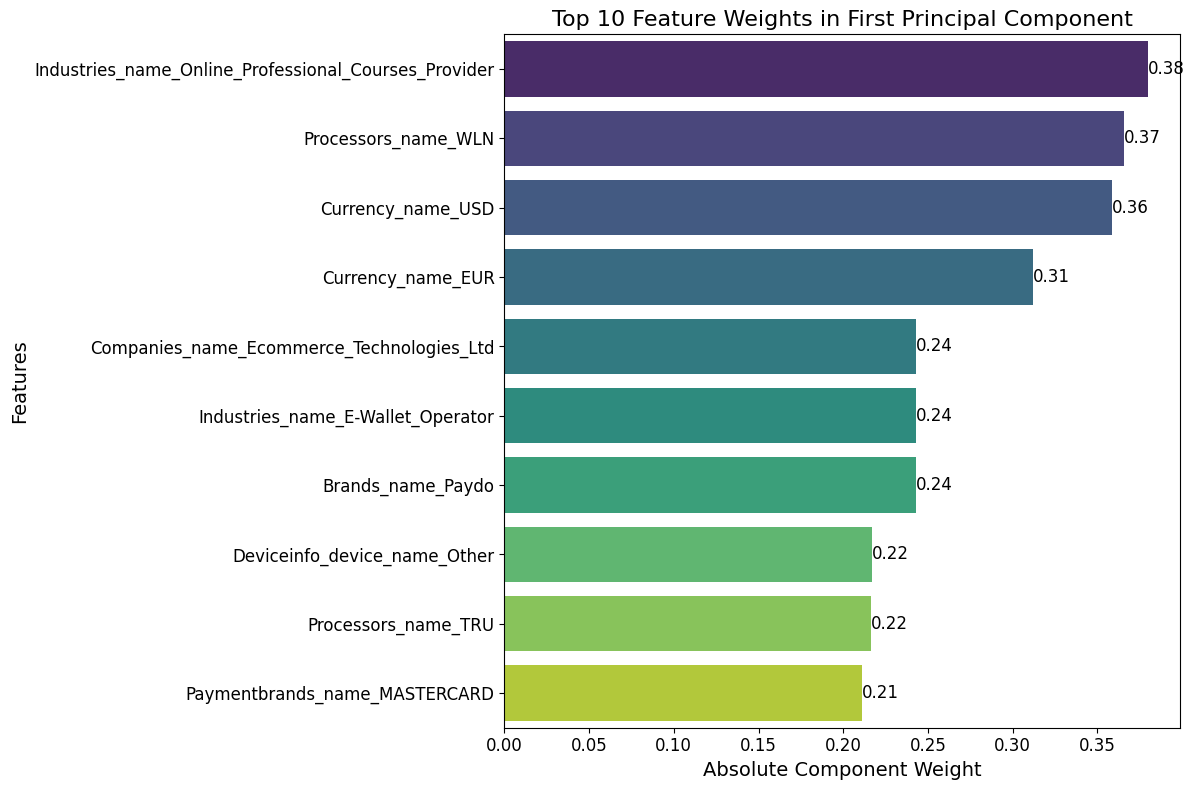

In [34]:
# Get the first principal component's eigenvector
first_component = pca.components_[0]

# Create a DataFrame to display the component along with their corresponding feature names
component_df = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': first_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df['Absolute Weight'] = np.abs(component_df['Component Weight'])
component_df = component_df.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 1:")
print(component_df)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute Weight', y='Feature', data=component_df.head(10), hue='Feature', dodge=False, palette='viridis', legend=False)
plt.xlabel('Absolute Component Weight', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 10 Feature Weights in First Principal Component', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Adding the value of component weights at the end of bars
for index, value in enumerate(component_df.head(10)['Absolute Weight']):
    plt.text(value, index, f"{value:.2f}", color='black', va='center', fontsize=12)

# Show the plot
plt.show()

Components of Component 2:
                                          Feature  Component Weight  \
13                          Environments_name_s2s         -0.413080   
12                           Environments_name_pp          0.383175   
2726            Industries_name_E-Wallet_Operator         -0.290031   
2796    Companies_name_Ecommerce_Technologies_Ltd         -0.290031   
193                             Brands_name_Paydo         -0.290031   
...                                           ...               ...   
2427           Issuers_name_POMELO_TECNOLOGIA_SAS         -0.000000   
1760  Issuers_name_BANCO_DE_CREDITO_E_INVERSIONES         -0.000000   
950                             Email_domain_1999         -0.000000   
498                Deviceinfo_device_name_PPA-LX2         -0.000000   
1460                             Email_domain_t-2         -0.000000   

      Absolute Weight  
13           0.413080  
12           0.383175  
2726         0.290031  
2796         0.290031  


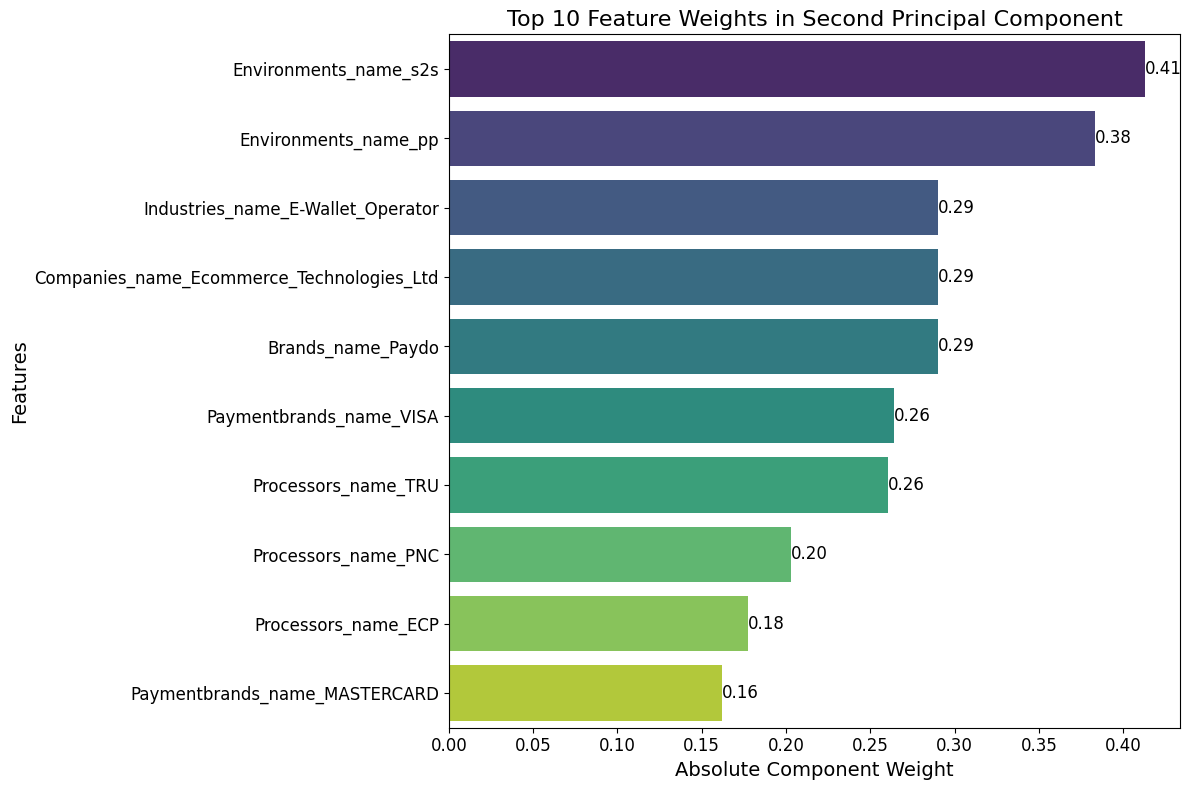

In [35]:
#Get the second principal component's eigenvector
second_component = pca.components_[1]

#Create a DataFrame to display the component along with their corresponding feature names
component_df2 = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': second_component})

#Sort the DataFrame by absolute component weights to visualize the most influential features
component_df2['Absolute Weight'] = np.abs(component_df2['Component Weight'])
component_df2 = component_df2.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 2:")
print(component_df2)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute Weight', y='Feature', data=component_df2.head(10), hue='Feature', dodge=False, palette='viridis', legend=False)
plt.xlabel('Absolute Component Weight', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 10 Feature Weights in Second Principal Component', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Adding the value of component weights at the end of bars
for index, value in enumerate(component_df2.head(10)['Absolute Weight']):
    plt.text(value, index, f"{value:.2f}", color='black', va='center', fontsize=12)

# Show the plot
plt.show()

Components of Component 3:
                                Feature  Component Weight  Absolute Weight
491        Deviceinfo_device_name_Other         -0.429416         0.429416
885      Deviceinfo_browser_name_Chrome         -0.405378         0.405378
1174                 Email_domain_gmail         -0.323961         0.323961
7                     Currency_name_USD         -0.283214         0.283214
846       Deviceinfo_device_name_iPhone          0.271739         0.271739
...                                 ...               ...              ...
2141              Issuers_name_GEM_VISA          0.000000         0.000000
2144               Issuers_name_GO2BANK          0.000000         0.000000
813     Deviceinfo_device_name_WAS-LX1A          0.000000         0.000000
812   Deviceinfo_device_name_W-V830-EEA          0.000000         0.000000
1460                   Email_domain_t-2          0.000000         0.000000

[2921 rows x 3 columns]


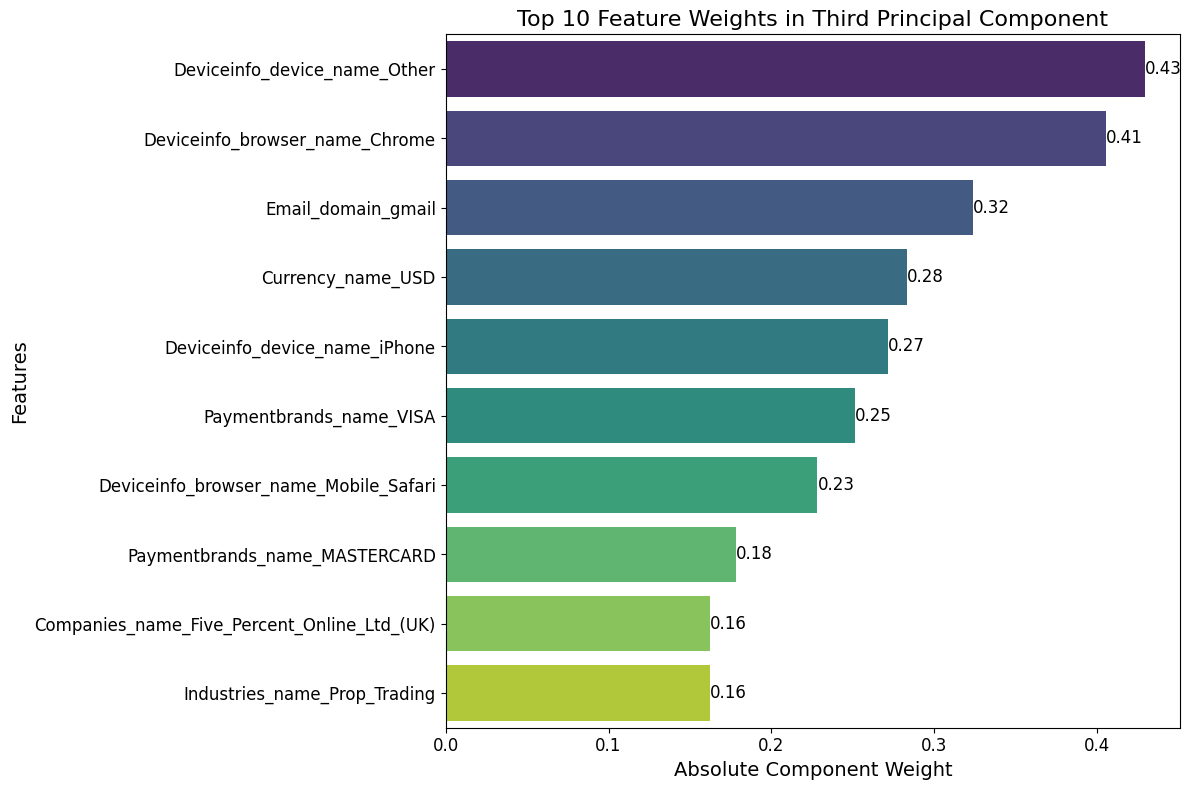

In [36]:
# Get the third principal component's eigenvector
third_component = pca.components_[2]

# Create a DataFrame to display the component along with their corresponding feature names
component_df3 = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': third_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df3['Absolute Weight'] = np.abs(component_df3['Component Weight'])
component_df3 = component_df3.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 3:")
print(component_df3)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute Weight', y='Feature', data=component_df3.head(10), hue='Feature', dodge=False, palette='viridis', legend=False)
plt.xlabel('Absolute Component Weight', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 10 Feature Weights in Third Principal Component', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Adding the value of component weights at the end of bars
for index, value in enumerate(component_df3.head(10)['Absolute Weight']):
    plt.text(value, index, f"{value:.2f}", color='black', va='center', fontsize=12)

# Show the plot
plt.show()


# Random Forest Model

##Testing and comparing different Hyperparameters

In [37]:
#Define a list of n_estimators values
n_estimators_list = [50, 100, 200, 300, 400]

#Define a list of max_depth values
max_depth_list = [None, 10]

#Define lists to store evaluation metrics
accuracy_lists = [[] for _ in max_depth_list]
precision_lists = [[] for _ in max_depth_list]
recall_lists = [[] for _ in max_depth_list]
f1_score_lists = [[] for _ in max_depth_list]

for n_estimators in n_estimators_list:
    for i, max_depth in enumerate(max_depth_list):
        #Initialize and train the Random Forest model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train_pca, y_train)

        #Predictions on validation set
        y_val_pred = model.predict(X_val_pca)

        #Accuracy evaluation
        accuracy = accuracy_score(y_val, y_val_pred)
        accuracy_lists[i].append(accuracy)

        #Precision, recall, and F1-score evaluation
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_val_pred, average='macro')
        precision_lists[i].append(precision)
        recall_lists[i].append(recall)
        f1_score_lists[i].append(f1_score)

        # Print current status
        print(f"Calculations for n_estimators={n_estimators}, max_depth={max_depth} completed.")

Calculations for n_estimators=50, max_depth=None completed.
Calculations for n_estimators=50, max_depth=10 completed.
Calculations for n_estimators=100, max_depth=None completed.
Calculations for n_estimators=100, max_depth=10 completed.
Calculations for n_estimators=200, max_depth=None completed.
Calculations for n_estimators=200, max_depth=10 completed.
Calculations for n_estimators=300, max_depth=None completed.
Calculations for n_estimators=300, max_depth=10 completed.
Calculations for n_estimators=400, max_depth=None completed.
Calculations for n_estimators=400, max_depth=10 completed.


##Plotting the results

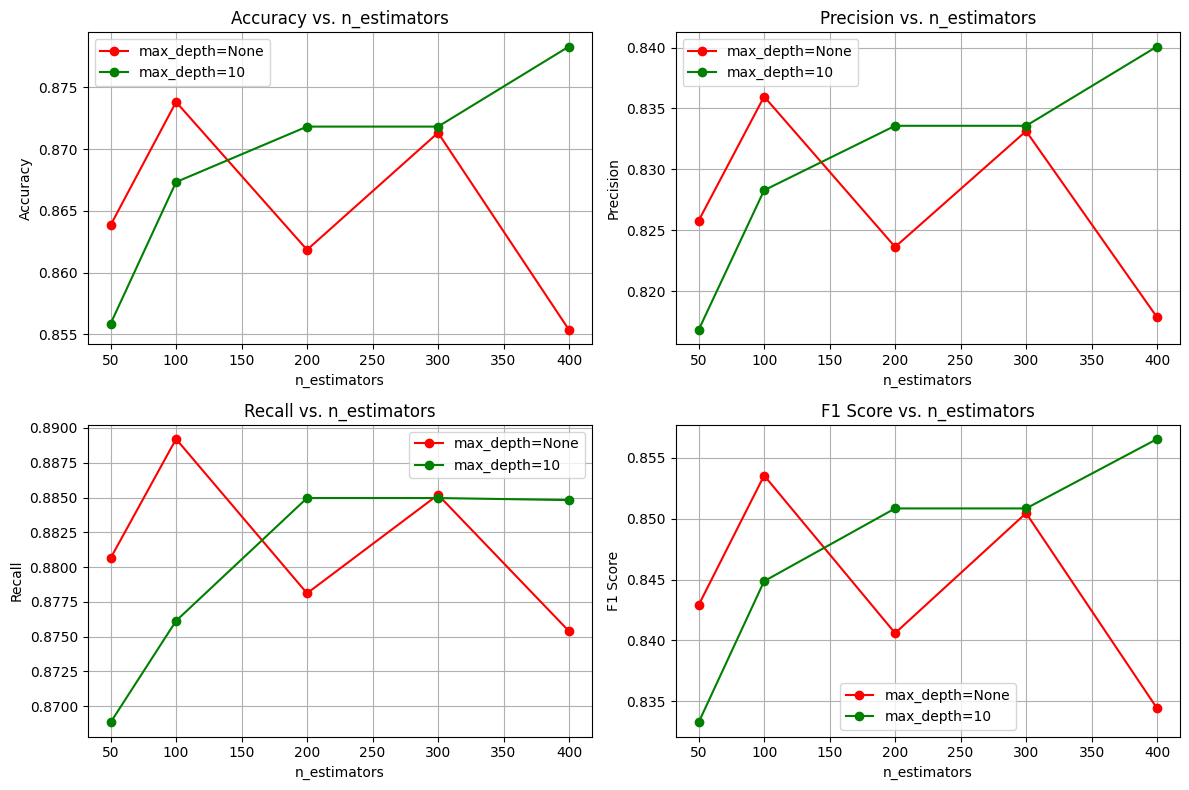

In [38]:
#Plot the results
plt.figure(figsize=(12, 8))

#Accuracy plot
plt.subplot(2, 2, 1)
for accuracy_list, max_depth, color in zip(accuracy_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, accuracy_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_estimators')
plt.legend()
plt.grid(True)

#Precision plot
plt.subplot(2, 2, 2)
for precision_list, max_depth, color in zip(precision_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, precision_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('Precision')
plt.title('Precision vs. n_estimators')
plt.legend()
plt.grid(True)

#Recall plot
plt.subplot(2, 2, 3)
for recall_list, max_depth, color in zip(recall_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, recall_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('Recall')
plt.title('Recall vs. n_estimators')
plt.legend()
plt.grid(True)

#F1 score plot
plt.subplot(2, 2, 4)
for f1_score_list, max_depth, color in zip(f1_score_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, f1_score_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. n_estimators')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##Final Model

In [39]:
#Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_pca, y_train)

#Predict on the test set
y_test_pred = model.predict(X_test_pca)

#Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

#Predict on the validation set
y_val_pred = model.predict(X_val_pca)

#Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Test set evaluation:
[[1375  104]
 [  83  903]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1479
           1       0.90      0.92      0.91       986

    accuracy                           0.92      2465
   macro avg       0.92      0.92      0.92      2465
weighted avg       0.92      0.92      0.92      2465

Validation set evaluation:
[[1251  209]
 [  57  488]]
              precision    recall  f1-score   support

           0       0.96      0.86      0.90      1460
           1       0.70      0.90      0.79       545

    accuracy                           0.87      2005
   macro avg       0.83      0.88      0.84      2005
weighted avg       0.89      0.87      0.87      2005



# Neural Network Model

##Testing and comparing different hyperparameters

In [40]:
# Define lists of hyperparameters to compare
batch_sizes = [16, 64]
epochs_list = [10, 20]
learning_rates = [0.001, 0.01]

# Define lists to store evaluation metrics
nn_accuracy_lists = []
nn_precision_lists = []
nn_recall_lists = []
nn_f1_score_lists = []

# Loop through hyperparameters
for batch_size in batch_sizes:
    for epochs in epochs_list:
        for learning_rate in learning_rates:
            # Define the neural network architecture
            model = Sequential([
                Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
                Dense(64, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

            # Compile the model with custom optimizer and learning rate
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            # Train the model
            history = model.fit(X_train_pca, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_pca, y_val), verbose=0)

            # Extract accuracy from history
            nn_accuracy = history.history['val_accuracy'][-1]
            nn_accuracy_lists.append(nn_accuracy)

            # Predict on the test set
            y_test_pred_proba = model.predict(X_test_pca)
            y_test_pred = (y_test_pred_proba > 0.5).astype(int)

            # Evaluate the model on the test set
            print(f"Evaluation for batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}:")
            print("Test set evaluation:")
            print(confusion_matrix(y_test, y_test_pred))
            print(classification_report(y_test, y_test_pred))

            # Predict on the validation set
            y_val_pred_proba = model.predict(X_val_pca)
            y_val_pred = (y_val_pred_proba > 0.5).astype(int)

            # Evaluate the model on the validation set
            print("Validation set evaluation:")
            print(confusion_matrix(y_val, y_val_pred))
            print(classification_report(y_val, y_val_pred))

            # Calculate precision, recall, and F1-score
            precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_val_pred, average='macro', zero_division=1)
            nn_precision_lists.append(precision)
            nn_recall_lists.append(recall)
            nn_f1_score_lists.append(f1_score)

78/78 [==============================] - 0s 1ms/step
Evaluation for batch_size=16, epochs=10, learning_rate=0.001:
Test set evaluation:
[[1368  111]
 [ 109  877]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1479
           1       0.89      0.89      0.89       986

    accuracy                           0.91      2465
   macro avg       0.91      0.91      0.91      2465
weighted avg       0.91      0.91      0.91      2465

63/63 [==============================] - 0s 2ms/step
Validation set evaluation:
[[1261  199]
 [  69  476]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1460
           1       0.71      0.87      0.78       545

    accuracy                           0.87      2005
   macro avg       0.83      0.87      0.84      2005
weighted avg       0.88      0.87      0.87      2005

78/78 [==============================] - 0s 1ms/step
Evaluation for batch_si

##Plotting the results

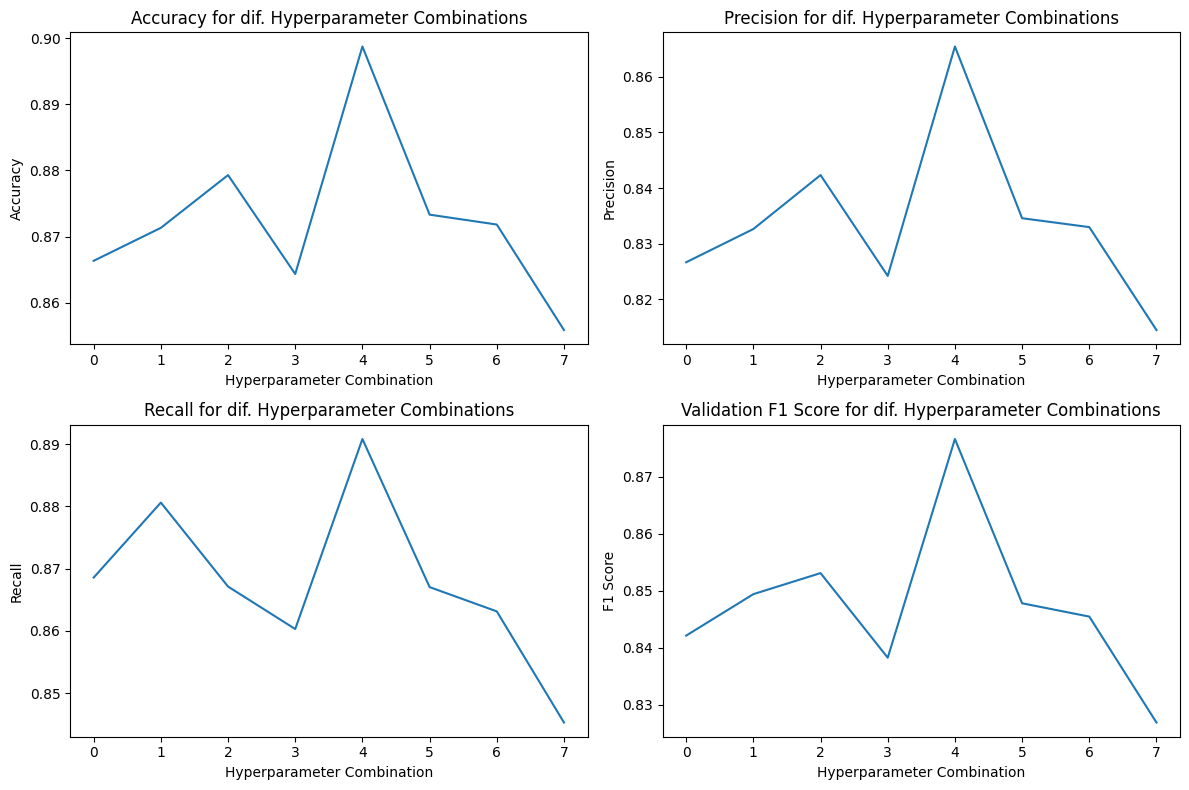

In [41]:
#Plot the results
plt.figure(figsize=(12, 8))

# Plotting accuracy
plt.subplot(2, 2, 1)
plt.plot(nn_accuracy_lists)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy for dif. Hyperparameter Combinations')

# Plotting precision
plt.subplot(2, 2, 2)
plt.plot(nn_precision_lists)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Precision')
plt.title('Precision for dif. Hyperparameter Combinations')

# Plotting recall
plt.subplot(2, 2, 3)
plt.plot(nn_recall_lists)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Recall')
plt.title('Recall for dif. Hyperparameter Combinations')

# Plotting F1-score
plt.subplot(2, 2, 4)
plt.plot(nn_f1_score_lists)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score for dif. Hyperparameter Combinations')

plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the spacing between subplots

plt.tight_layout()

plt.show()

##Final Model

In [42]:
#Final hyperparameters
batch_size = 16
epochs = 20
learning_rate = 0.01

#Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with custom optimizer and learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pca, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_pca, y_val), verbose=1)

# Extract accuracy from history
nn_accuracy = history.history['val_accuracy'][-1]
nn_accuracy_lists.append(nn_accuracy)

# Predict on the test set
y_test_pred_proba = model.predict(X_test_pca)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Evaluate the model on the test set
print(f"Evaluation for batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}:")
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred_proba = model.predict(X_val_pca)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Epoch 1/20
1073/1073 [==============================] - 4s 3ms/step - loss: 0.3360 - accuracy: 0.8629 - val_loss: 0.3087 - val_accuracy: 0.8763
Epoch 2/20
1073/1073 [==============================] - 2s 2ms/step - loss: 0.3003 - accuracy: 0.8773 - val_loss: 0.2904 - val_accuracy: 0.8863
Epoch 3/20
1073/1073 [==============================] - 2s 2ms/step - loss: 0.2868 - accuracy: 0.8801 - val_loss: 0.3129 - val_accuracy: 0.8763
Epoch 4/20
1073/1073 [==============================] - 2s 2ms/step - loss: 0.2787 - accuracy: 0.8822 - val_loss: 0.3612 - val_accuracy: 0.8579
Epoch 5/20
1073/1073 [==============================] - 2s 2ms/step - loss: 0.2685 - accuracy: 0.8865 - val_loss: 0.3345 - val_accuracy: 0.8703
Epoch 6/20
1073/1073 [==============================] - 3s 3ms/step - loss: 0.2637 - accuracy: 0.8872 - val_loss: 0.3419 - val_accuracy: 0.8733
Epoch 7/20
1073/1073 [==============================] - 3s 3ms/step - loss: 0.2562 - accuracy: 0.8905 - val_loss: 0.3208 - val_accuracy: